In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Metadata saved to output plots
METADATA = {
    "Contributor": "Alexander Gude",
    "Rights": "CC-BY-SA 4.0"
}

In [3]:
# Show plots inline
%matplotlib inline

# Helper functions

In [4]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.

def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.
    
    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.
        
    Returns:
        (fig, ax): A Matplotlib figure and axis object.
        
    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)
    
    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL
    
    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"
    
    # Figure output
    plt.rcParams["savefig.dpi"] = 300
    
    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return fig, ax

In [5]:
# https://stackoverflow.com/questions/19073683/matplotlib-overlapping-annotations-text

def draw_left_legend(ax, nudges=None, fontsize=20):
    """Draw legend labels at the end of each line.

    Args:
        ax (matplotlib axis): The axis to draw on.
        nudges (Dict[str, float], default None): An optional mapping of line label 
            to y adjustment for the label. Useful for preventing overlap. If a key 
            is missing then that line is not adjusted.
        fontsize (int, default 20): A fontsize understood by matplotlib. Either an 
            int or a size string.
            
    Returns: None

    """
    ax.get_legend().remove()
    for line in ax.lines:
        label = line.get_label()      
        color = line.get_color()

        y = line.get_ydata()[-1]
        x = line.get_xdata()[-1]
        
        nudge_y = 0
        if nudges is not None:
            nudge_y = nudges.get(label, 0) 

        ax.annotate(
            s=label,
            xy=(x, y),
            xytext=(10, 0+nudge_y),
            textcoords='offset points',
            color=color,
            size=fontsize,
            weight="bold",
            va="center"
        )

In [6]:
def plot_time_series(df, ax, date_col, category_col, resample_frequency=None, aggfunc="size", linewidth=3):
    """Draws a timeseries for each distinct item in the category column

    Args:
        df (Pandas DataFrame): The dataframe of data, containing `date_col` and 
            `category_col`.
        ax (matplotlib axis): The axis to draw on.
        date_col (str): The name of the column containing datetime objects. 
            Converted to a DatetimeIndex with `pandas.to_datetime()`.
        category_col (str): The name of the column containing the categorical
            variable to plot. Will draw one time series per value.
        resample_frequency (str, default None): A frequency string understood
            by `pandas.DataFrame.resample`. If not provided uses the natural
            frequency of the data.
        aggfunc (string or function, default 'size'): Any object understood by
            `pandas.pivot_table(aggfunc=...)`, used to aggregate rows in time.
        linewidth (int, default 3): Width of the lines to draw.

    Returns: None

    """
    
    # Save label because it will be over-writen by Pandas
    xlabel = ax.get_xlabel()
    
    tmp_df = df.set_index(date_col)
    tmp_df.index = pd.to_datetime(tmp_df.index)
    pivot = tmp_df.pivot_table(
        index=tmp_df.index, 
        columns="vehicle_make", 
        aggfunc=aggfunc, 
        fill_value=0,
    )
    
    if resample_frequency is not None:
        pivot = pivot.resample(resample_frequency).sum()
        
    pivot.plot(ax=ax, linewidth=linewidth)
    
    # Restore the label
    ax.set_xlabel(xlabel)

# Plots

In [8]:
pd.concat((
    df[df['vehicle_make']=="Honda"].sample(2),
    df[df['vehicle_make']=="Other"].sample(2),
    df[df['vehicle_make']=="Toyota"].sample(2),
))

,collision_date,vehicle_make
847115,2019-07-25,Honda
85214,2019-02-14,Honda
1043507,2019-12-03,Other
1402063,2020-08-12,Other
884534,2019-08-18,Toyota
478032,2019-12-29,Toyota


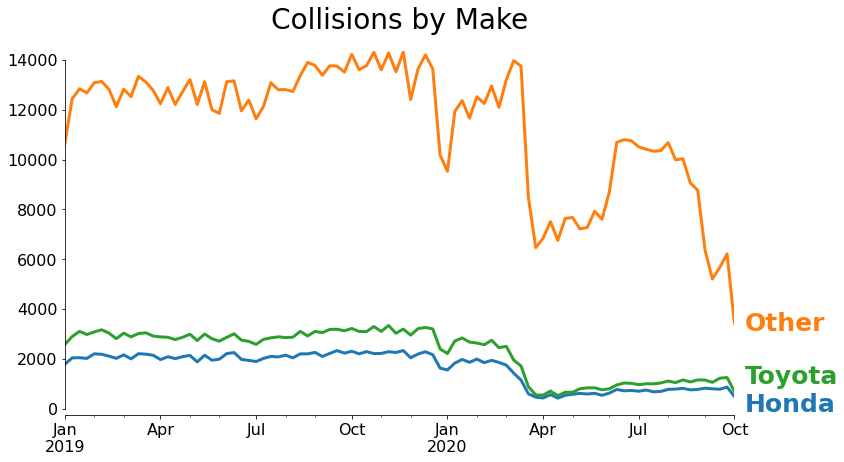

In [9]:
fig, ax = setup_plot(title="Collisions by Make")

pivot = plot_time_series(df, ax, date_col=DATE_COL, category_col="vehicle_make", resample_frequency="W")

nudges = {"Toyota": 15, "Honda": -8}
draw_left_legend(ax, nudges=nudges, fontsize=25)

sns.despine(trim=True)

save_plot(fig, "/tmp/make_collision_in_time.svg")